## Experiment "cellTypeSpecificCellNet"

Same as "cellTypeSpecific", but deriving base networks from CellNet instead of ANANSE.

In [1]:
EXPERIMENT_NAME="cellTypeSpecificCellNetHuGene_v1"

In [2]:
import warnings
warnings.filterwarnings('ignore')
import importlib
import os
import gc
import re
import sys
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
import joblib 
#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [3]:
# Deal with various file paths specific to this project
PROJECT_PATH = '/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/'
os.chdir(PROJECT_PATH + "benchmarking/")
try:
    os.makedirs("results/" + EXPERIMENT_NAME)
except:
    pass

sys.path.append(os.path.expanduser(PROJECT_PATH + 'networks/load_networks'))
sys.path.append(os.path.expanduser(PROJECT_PATH + 'perturbations/load_perturbations')) 
sys.path.append(os.path.expanduser(PROJECT_PATH + 'benchmarking/evaluator')) 
import evaluator
import load_networks
import load_perturbations
importlib.reload(evaluator) 
importlib.reload(load_networks) 
importlib.reload(load_perturbations)
os.environ["GRN_PATH"]           = PROJECT_PATH + "networks/networks"
os.environ["PERTURBATION_PATH"]  = PROJECT_PATH + "perturbations/perturbations"
load_networks.load_grn_metadata()

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


,name,description,data_used,species,link,citation,is_ready,first_column
name,,,,,,,,
cellnet_human_Hg1332,cellnet_human_Hg1332,CLR analysis of microarray data pulled off GEO,microarrays (HG133 plus 2 and HuGene 1.0),human,http://pcahan1.github.io/cellnetr/,"Cahan, P., Li, H., Morris, S. A., Da Rocha, E....",yes,symmetric
cellnet_human_Hugene,cellnet_human_Hugene,CLR analysis of microarray data pulled off GEO,microarrays (HG133 plus 2 and HuGene 1.0),human,http://pcahan1.github.io/cellnetr/,"Cahan, P., Li, H., Morris, S. A., Da Rocha, E....",yes,symmetric
cellnet_mouse_4302,cellnet_mouse_4302,CLR analysis of microarray data pulled off GEO,microarrays (MoGene 1.0 and 430.2),mouse,http://pcahan1.github.io/cellnetr/,"Cahan, P., Li, H., Morris, S. A., Da Rocha, E....",yes,symmetric
cellnet_mouse_mogene,cellnet_mouse_mogene,CLR analysis of microarray data pulled off GEO,microarrays (MoGene 1.0 and 430.2),mouse,http://pcahan1.github.io/cellnetr/,"Cahan, P., Li, H., Morris, S. A., Da Rocha, E....",yes,symmetric
encode-nets_human,encode-nets_human,TF-ChIP data (ENCODE),TF ChIP,human,http://encodenets.gersteinlab.org/,"Gerstein, M. B., Kundaje, A., Hariharan, M., L...",yes,regulator
fntm,fntm,Bayesian classifier based on a ground truth da...,everything,mouse,http://fntm.princeton.edu/download/,"Goya, J., Wong, A. K., Yao, V., Krishnan, A., ...",yes,symmetric
humanbase,humanbase,Bayesian classifier based on a ground truth da...,everything,human,https://hb.flatironinstitute.org/download,"Greene, C. S., Krishnan, A., Wong, A. K., Ricc...",yes,symmetric
chea,chea,TF ChIP data (miscellaneous),ChIP-X,human_mouse,http://amp.pharm.mssm.edu/Harmonizome/resource...,"Lachmann, A., Xu, H., Krishnan, J., Berger, S....",yes,regulator
csnets,csnets,Motif analysis + RNA integration,"Dnase, RNA",human,http://bioinfo.au.tsinghua.edu.cn/jianglab/CSN...,"Ma, S., Jiang, T., & Jiang, R. (2018). Constru...",yes,regulator


### Networks setup

This experiment aims to test a variety of published sparse regulatory network structures. 

In [6]:
networks = {
    'dense': evaluator.makeRandomNetwork(density = 1),
    'CellNet_all': evaluator.networkEdgesToMatrix(load_networks.load_grn_all_subnetworks("cellnet_human_Hugene"))
}

In [7]:
for network in load_networks.list_subnetworks("cellnet_human_Hugene"):
    print("Loading " + network)
    if not network in networks:
        networks[network] = evaluator.networkEdgesToMatrix(load_networks.load_grn_by_subnetwork("cellnet_human_Hugene", network))
    gc.collect()
    
network_sizes = pd.DataFrame({bn:evaluator.countMatrixEdges(networks[bn]) for bn in networks}, index = ["numEdges"])
network_sizes = network_sizes.T.reset_index().rename({"index":"network"}, axis = 1)
network_sizes

Loading macrophage.csv.gz
Loading heart.csv.gz
Loading bcell.csv.gz
Loading esc.csv.gz
Loading fibroblast.csv.gz
Loading tcell.csv.gz
Loading muscleSkel.csv.gz
Loading kidney.csv.gz
Loading endothelial.csv.gz
Loading liver.csv.gz
Loading hspc.csv.gz
Loading lung.csv.gz
Loading skin.csv.gz


,network,numEdges
0,dense,102313295.0
1,CellNet_all,157408.0
2,macrophage.csv.gz,11084.0
3,heart.csv.gz,12528.0
4,bcell.csv.gz,22934.0
5,esc.csv.gz,32864.0
6,fibroblast.csv.gz,15398.0
7,tcell.csv.gz,22582.0
8,muscleSkel.csv.gz,12586.0
9,kidney.csv.gz,9560.0


### Data setup

We use the Nakatake et al data. This experiment is on per-cluster versus shared regression models, so we run Leiden clustering at many different resolutions.

In [8]:
ko_lab_esc_data = sc.read_h5ad(os.environ["PERTURBATION_PATH"] + "/nakatake/" + "test.h5ad")
cellFateClassifier = joblib.load(os.environ["PERTURBATION_PATH"] + "/nakatake/" + "classifier.joblib") 

In [9]:
ko_lab_esc_data.obs.columns

Index(['perturbation', 'is_control', 'fraction_missing', 'leiden',
       'fake_cluster'],
      dtype='object')

In [10]:
allowedRegulators = set.union(*[set(networks[key].columns) for key in networks])
ko_lab_esc_data_train, ko_lab_esc_data_heldout, perturbationsToPredict = \
    evaluator.splitData(ko_lab_esc_data, allowedRegulators, minTestSetSize=250)

Example perturbations formatted as 
 (gene, expression after perturbation)
[('ALX3', 2.829177), ('ALX3', 3.583377), ('ARNT2', 3.8641534), ('ARNT2', 2.533805), ('ASCL2', 0.61448115)]
Test set size:
263
Training set size:
250


### Experimental metadata

In [11]:
n_networks = len(networks.keys())
experiments = pd.DataFrame({"network":[n for n in networks.keys()], 
                            "p":[1]*n_networks,
                            "threshold_number":[int(network_sizes['numEdges'].max())]*n_networks,
                            "pruning":["none"]*n_networks})
experiments["index"] = experiments.index
experiments.to_csv("results/" + EXPERIMENT_NAME + "/networkExperiments.csv")
experiments

,network,p,threshold_number,pruning,index
0,dense,1,102313295,none,0
1,CellNet_all,1,102313295,none,1
2,macrophage.csv.gz,1,102313295,none,2
3,heart.csv.gz,1,102313295,none,3
4,bcell.csv.gz,1,102313295,none,4
5,esc.csv.gz,1,102313295,none,5
6,fibroblast.csv.gz,1,102313295,none,6
7,tcell.csv.gz,1,102313295,none,7
8,muscleSkel.csv.gz,1,102313295,none,8
9,kidney.csv.gz,1,102313295,none,9


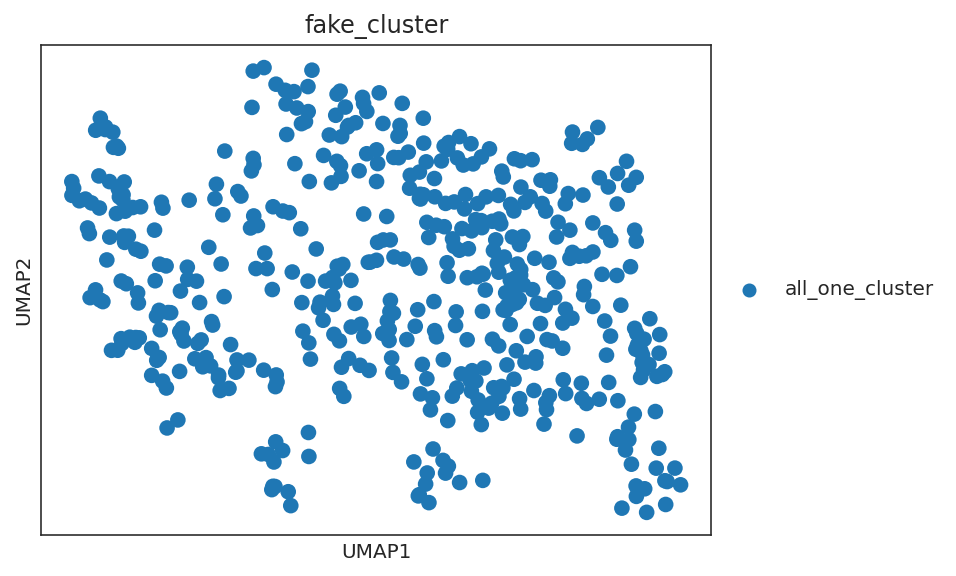

Working on results/cellTypeSpecificCellNetHuGene_v1/0.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZSCAN5A
ALX3 ALX3 ARNT2 ARNT2 ASCL2 ASCL2 ATF1 ATF1 ATF3 ATF3 BARX2 BARX2 BATF BATF BCL6 BCL6 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CCNE1 
Prediction failed for CCNE1 with error Gene CCNE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CCNE1 
Prediction failed for CCNE1 with error Gene CCNE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CDYL 
Prediction failed for CDYL with error Gene CDYL is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CDYL 
Prediction failed for CDYL with error Gene CDYL is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CEBPA CEBPA CEBPB CEBPB CEBPD CEBPD CENPX CERS2 CERS2 CHD4 CHD4 CREB1 CREB1 CRY1 
Prediction failed for CRY1 with error Gene CRY1 is no

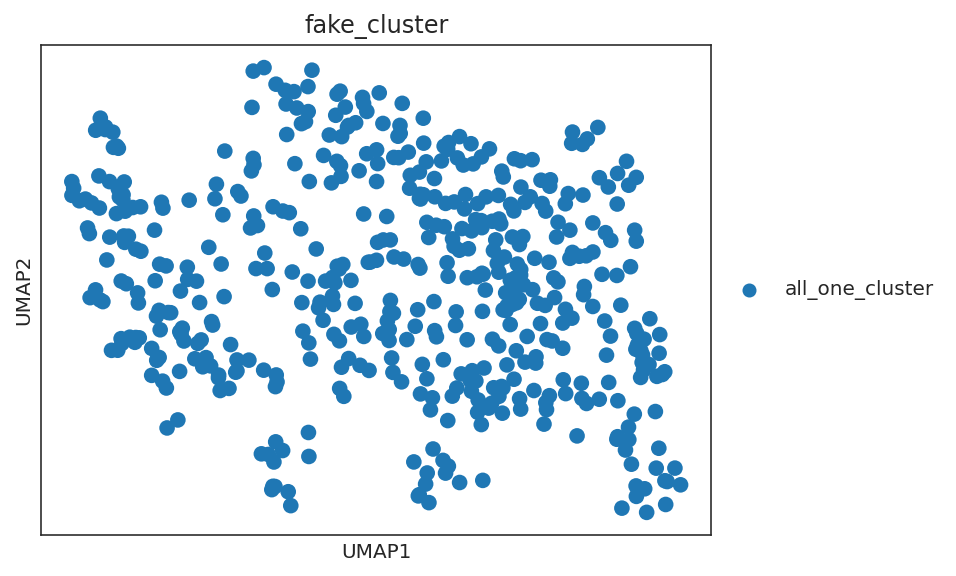

Working on results/cellTypeSpecificCellNetHuGene_v1/1.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/1290 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 1149 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 ARNT2 ASCL2 ASCL2 ATF1 
Prediction failed for ATF1 with error Gene ATF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF1 
Prediction failed for ATF1 with error Gene ATF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF3 ATF3 BARX2 
Prediction failed for BARX2 with error Gene BARX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
BARX2 
Prediction failed for BARX2 with error Gene BA

GTF3C2 GTF3C2 HESX1 HESX1 HHEX HHEX HMGA2 HMGA2 HMGXB4 
Prediction failed for HMGXB4 with error Gene HMGXB4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
HMGXB4 
Prediction failed for HMGXB4 with error Gene HMGXB4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
HNF1A HOPX HOPX HOXA2 HOXA2 HOXA9 
Prediction failed for HOXA9 with error Gene HOXA9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA9 
Prediction failed for HOXA9 with error Gene HOXA9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXB1 
Prediction failed for HOXB1 with error Gene HOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXB1 
Prediction failed for HOXB1 with error Gene HOXB1 is not included in the base GRN; It is not TF or TF motif informa

NKX2-1 NKX2-1 NKX6-3 
Prediction failed for NKX6-3 with error Gene NKX6-3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NKX6-3 
Prediction failed for NKX6-3 with error Gene NKX6-3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR2C2 
Prediction failed for NR2C2 with error Gene NR2C2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR2C2 
Prediction failed for NR2C2 with error Gene NR2C2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR2E1 
Prediction failed for NR2E1 with error Gene NR2E1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR2E1 
Prediction failed for NR2E1 with error Gene NR2E1 is not included in the base GRN; It is not TF or TF motif infor

SNAI2 SNAI2 SNAI3 SNAI3 SOX10 
Prediction failed for SOX10 with error Gene SOX10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX10 
Prediction failed for SOX10 with error Gene SOX10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX15 
Prediction failed for SOX15 with error Gene SOX15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX15 
Prediction failed for SOX15 with error Gene SOX15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX17 SOX17 SOX7 SOX7 SPI1 SPI1 SPIB SPIB SPIC SPIC SPIC SPZ1 SPZ1 STAG1 
Prediction failed for STAG1 with error Gene STAG1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
STAG1 
Prediction failed for STAG1 with error Gen

ARID3B ARID3B ATF4 
Prediction failed for ATF4 with error Gene ATF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF4 
Prediction failed for ATF4 with error Gene ATF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
BMI1 
Prediction failed for BMI1 with error Gene BMI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
BMI1 
Prediction failed for BMI1 with error Gene BMI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
BMP7 BMP7 BRF1 
Prediction failed for BRF1 with error Gene BRF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
BRF1 
Prediction failed for BRF1 with error Gene BRF1 is not included in the base GRN; It is not TF or TF motif information is not 

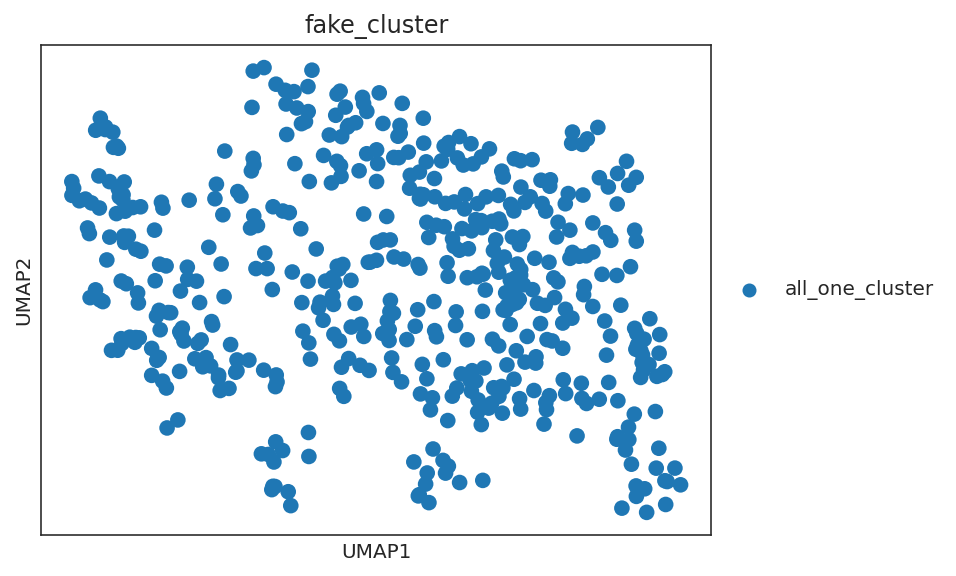

Working on results/cellTypeSpecificCellNetHuGene_v1/2.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/181 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 153 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the ba

EHF EHF ELF1 
Prediction failed for ELF1 with error Gene ELF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELF1 
Prediction failed for ELF1 with error Gene ELF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELF5 
Prediction failed for ELF5 with error Gene ELF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELF5 
Prediction failed for ELF5 with error Gene ELF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Canno

MYC MYC MYF6 
Prediction failed for MYF6 with error Gene MYF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYF6 
Prediction failed for MYF6 with error Gene MYF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NANOG 
Prediction failed for NANOG with error Gene NANOG is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NANOG 
Prediction failed for NANOG with error Gene NANOG is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD1 
Prediction failed for NEUROD1 with error Gene NEUROD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD1 
Prediction failed for NEUROD1 with error Gene NEUROD1 is not included in the base GRN; It is not TF or TF motif information

PPARG PPARG PTF1A 
Prediction failed for PTF1A with error Gene PTF1A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PTF1A 
Prediction failed for PTF1A with error Gene PTF1A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RARA 
Prediction failed for RARA with error Gene RARA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RARA 
Prediction failed for RARA with error Gene RARA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RASL10A 
Prediction failed for RASL10A with error Gene RASL10A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RASL10A 
Prediction failed for RASL10A with error Gene RASL10A is not included in the base GRN; It is not TF or TF motif informa

SPI1 SPI1 SPIB 
Prediction failed for SPIB with error Gene SPIB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIB 
Prediction failed for SPIB with error Gene SPIB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIC 
Prediction failed for SPIC with error Gene SPIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIC 
Prediction failed for SPIC with error Gene SPIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIC 
Prediction failed for SPIC with error Gene SPIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPZ1 
Prediction failed for SPZ1 with error Gene SPZ1 is not included in the base GRN; It is not TF or TF motif information is not available. Can

HOXA1 HOXA1 IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF6 
Prediction failed for KLF6 with error Gene KLF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF6 
Prediction failed for KLF6 with error Gene KLF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
LBX2 
Prediction failed for LBX2 with error Gene LBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
LBX2 
Prediction failed for LBX2 with error Gene LBX2 is not included in the base GRN; It is not TF or TF motif information is not availa

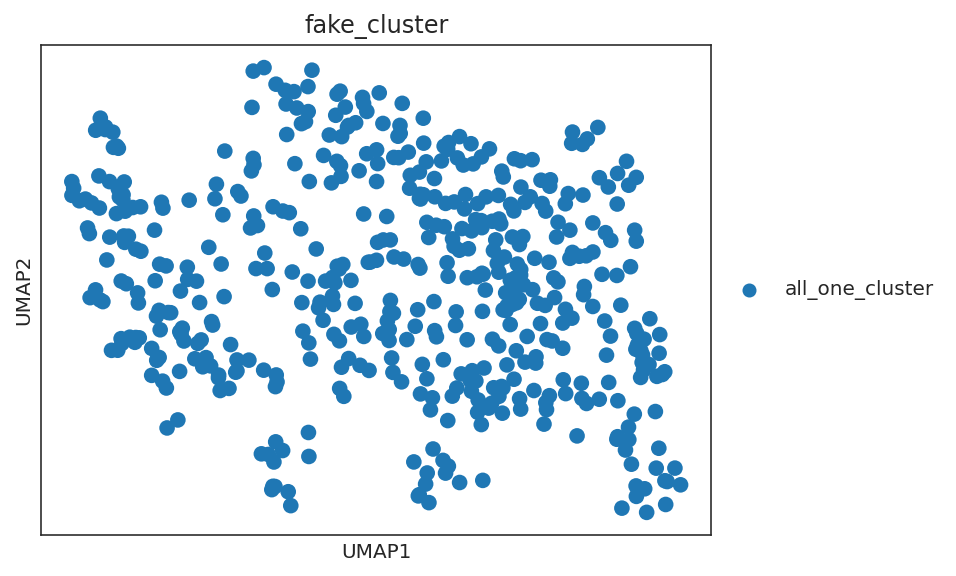

Working on results/cellTypeSpecificCellNetHuGene_v1/3.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/127 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 111 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the ba

E2F6 E2F6 EBF1 
Prediction failed for EBF1 with error Gene EBF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EBF1 
Prediction failed for EBF1 with error Gene EBF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EHF 
Prediction failed for EHF with error Gene EHF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EHF 
Prediction failed for EHF with error Gene EHF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELF1 
Prediction failed for ELF1 with error Gene ELF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELF1 
Prediction failed for ELF1 with error Gene ELF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot pe

FOXN3 FOXN3 FOXO3 
Prediction failed for FOXO3 with error Gene FOXO3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXO3 
Prediction failed for FOXO3 with error Gene FOXO3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXP3 
Prediction failed for FOXP3 with error Gene FOXP3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXP3 
Prediction failed for FOXP3 with error Gene FOXP3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA6 GATA6 GLI1 
Prediction failed for GLI1 with error Gene GLI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GLI1 
Prediction failed for GLI1 with error Gene GLI1 is not included in the base GRN; It is not TF or TF motif informa

MYF6 MYF6 NANOG 
Prediction failed for NANOG with error Gene NANOG is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NANOG 
Prediction failed for NANOG with error Gene NANOG is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD1 
Prediction failed for NEUROD1 with error Gene NEUROD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD1 
Prediction failed for NEUROD1 with error Gene NEUROD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG1 
Prediction failed for NEUROG1 with error Gene NEUROG1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG1 
Prediction failed for NEUROG1 with error Gene NEUROG1 is not included in the base GRN; It is not TF or 

TBX5 TBX5 TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF12 
Prediction failed for TCF12 with error Gene TCF12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF12 
Prediction failed for TCF12 with error Gene TCF12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF23 
Prediction failed for TCF23 with error Gene TCF23 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF23 
Prediction failed for TCF23 with error Gene TCF23 is not included in the base GRN; It is not TF or TF motif information is not av

TEAD2 TEAD2 TEF 
Prediction failed for TEF with error Gene TEF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TEF 
Prediction failed for TEF with error Gene TEF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THRA 
Prediction failed for THRA with error Gene THRA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THRA 
Prediction failed for THRA with error Gene THRA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TNF 
Prediction failed for TNF with error Gene TNF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TNF 
Prediction failed for TNF with error Gene TNF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perfor

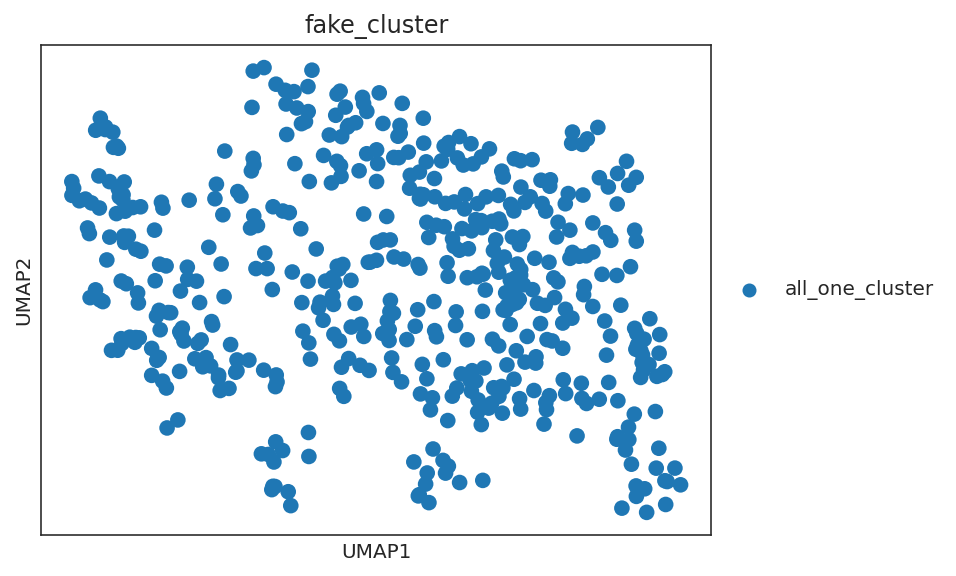

Working on results/cellTypeSpecificCellNetHuGene_v1/4.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/221 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 204 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 ASCL2 ATF1 
Prediction failed for ATF1 with error Gene ATF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF1 
Prediction failed for ATF1 with error Gene ATF1 is not included in 

ELF1 ELF1 ELF5 
Prediction failed for ELF5 with error Gene ELF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELF5 
Prediction failed for ELF5 with error Gene ELF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Can

HHEX HHEX HMGA2 
Prediction failed for HMGA2 with error Gene HMGA2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGA2 
Prediction failed for HMGA2 with error Gene HMGA2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGXB4 
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGXB4 
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HNF1A 
Prediction failed for HNF1A with error Gene HNF1A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOPX 
Prediction failed for HOPX with error Gene HOPX is not included in the base GRN; It is not TF or TF motif information 

NFATC1 NFATC1 NFE2L1 
Prediction failed for NFE2L1 with error Gene NFE2L1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFIC 
Prediction failed for NFIC with error Gene NFIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFIC 
Prediction failed for NFIC with error Gene NFIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFYB 
Prediction failed for NFYB with error Gene NFYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFYB 
Prediction failed for NFYB with error Gene NFYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NKX2-1 
Prediction failed for NKX2-1 with error Gene NKX2-1 is not included in the base GRN; It is not TF or TF motif information is no

RUNX1 RUNX1 RUNX3 RUNX3 RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SAP30 
Prediction failed for SAP30 with error Gene SAP30 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIM1 
Prediction failed for SIM1 with error Gene SIM1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIM1 
Prediction failed for SIM1 with error Gene SIM1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIN3A 
Prediction failed for SIN3A with error Gene SIN3A is not included in the base GRN; It is not TF or TF motif i

TCF4 TCF4 TCF7L2 TCF7L2 TEAD4 TEAD4 TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2C 
Prediction failed for TFAP2C with error Gene TFAP2C is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2C 
Prediction failed for TFAP2C with error Gene TFAP2C is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFCP2L1 
Prediction failed for TFCP2L1 with error Gene TFCP2L1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFCP2L1 
Prediction failed for TFCP2L1 with error Gene TFCP2L1 is not included in the 

CXXC5 CXXC5 DBX1 
Prediction failed for DBX1 with error Gene DBX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DBX1 
Prediction failed for DBX1 with error Gene DBX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DBX2 
Prediction failed for DBX2 with error Gene DBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DBX2 
Prediction failed for DBX2 with error Gene DBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
E2F5 E2F5 ETV4 
Prediction failed for ETV4 with error Gene ETV4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV4 
Prediction failed for ETV4 with error Gene ETV4 is not included in the base GRN; It is not TF or TF motif information is not av

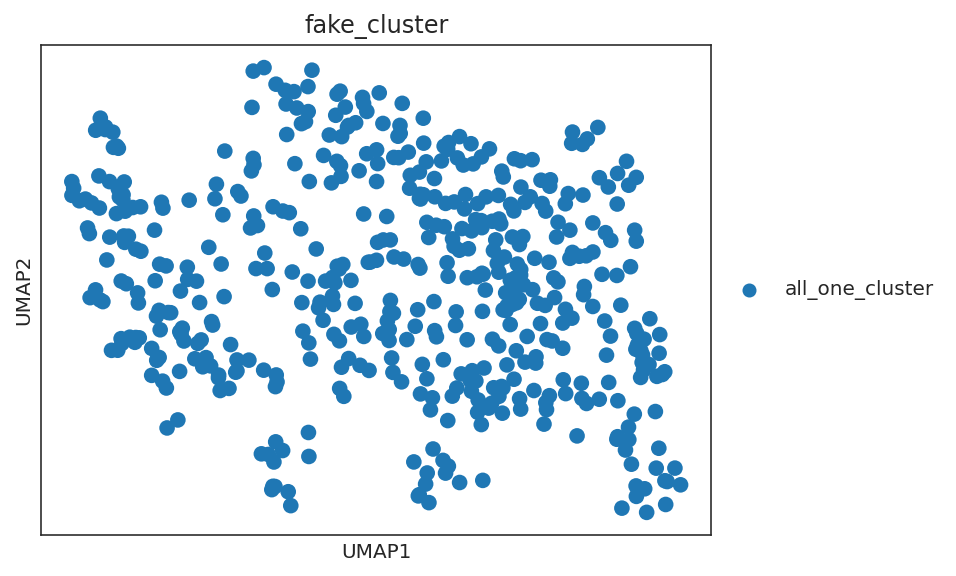

Working on results/cellTypeSpecificCellNetHuGene_v1/5.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/264 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 229 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the ba

FOXM1 FOXM1 FOXN3 
Prediction failed for FOXN3 with error Gene FOXN3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXN3 
Prediction failed for FOXN3 with error Gene FOXN3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXO3 
Prediction failed for FOXO3 with error Gene FOXO3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXO3 
Prediction failed for FOXO3 with error Gene FOXO3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXP3 
Prediction failed for FOXP3 with error Gene FOXP3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXP3 
Prediction failed for FOXP3 with error Gene FOXP3 is not included in the base GRN; It is not TF or TF motif information i

KDM5B KDM5B KLF1 
Prediction failed for KLF1 with error Gene KLF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF1 
Prediction failed for KLF1 with error Gene KLF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF11 
Prediction failed for KLF11 with error Gene KLF11 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF11 
Prediction failed for KLF11 with error Gene KLF11 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF14 
Prediction failed for KLF14 with error Gene KLF14 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF14 
Prediction failed for KLF14 with error Gene KLF14 is not included in the base GRN; It is not TF or TF motif information is not 

OTX2 OTX2 PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PATZ1 PATZ1 PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif inf

SMARCA4 SMARCA4 SMARCB1 
Prediction failed for SMARCB1 with error Gene SMARCB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMARCB1 
Prediction failed for SMARCB1 with error Gene SMARCB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMC3 
Prediction failed for SMC3 with error Gene SMC3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMC3 
Prediction failed for SMC3 with error Gene SMC3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI1 
Prediction failed for SNAI1 with error Gene SNAI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI1 
Prediction failed for SNAI1 with error Gene SNAI1 is not included in the base GRN; It is not TF or TF motif inf

ZMAT4 ZMAT4 ZMYND12 
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMYND12 
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF217 
Prediction failed for ZNF217 with error Gene ZNF217 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF263 
Prediction failed for ZNF263 with error Gene ZNF263 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF263 
Prediction failed for ZNF263 with error Gene ZNF263 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZNF281 
Prediction failed for ZNF281 with error Gene ZNF281 is not included in the base GRN; It is not TF o

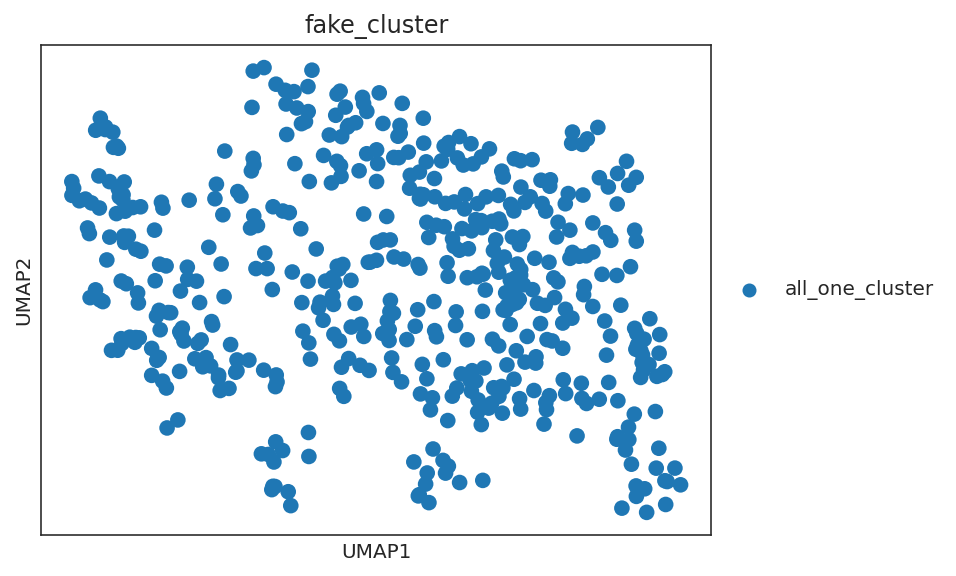

Working on results/cellTypeSpecificCellNetHuGene_v1/6.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/236 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 214 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the ba

ELL2 ELL2 EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EOMES 
Prediction failed for EOMES with error Gene EOMES is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EOMES 
Prediction failed for EOMES with error Gene EOMES is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESRRA 
Prediction failed for ESRRA with error Gene ESRRA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESRRA 
Prediction failed for ESRRA with error Gene ESRRA is not included in the base GRN; It is not TF or TF motif information is not availabl

JAG1 JAG1 JARID2 
Prediction failed for JARID2 with error Gene JARID2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JARID2 
Prediction failed for JARID2 with error Gene JARID2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JUN 
Prediction failed for JUN with error Gene JUN is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JUN 
Prediction failed for JUN with error Gene JUN is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JUNB 
Prediction failed for JUNB with error Gene JUNB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JUNB 
Prediction failed for JUNB with error Gene JUNB is not included in the base GRN; It is not TF or TF motif information is not availabl

NR2F2 NR2F2 NR3C1 
Prediction failed for NR3C1 with error Gene NR3C1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR3C1 
Prediction failed for NR3C1 with error Gene NR3C1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NRF1 
Prediction failed for NRF1 with error Gene NRF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NRF1 
Prediction failed for NRF1 with error Gene NRF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NSD2 
Prediction failed for NSD2 with error Gene NSD2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NSD2 
Prediction failed for NSD2 with error Gene NSD2 is not included in the base GRN; It is not TF or TF motif information is not availa

RUNX1 RUNX1 RUNX3 
Prediction failed for RUNX3 with error Gene RUNX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUNX3 
Prediction failed for RUNX3 with error Gene RUNX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SAP30 
Prediction failed for SAP30 with error Gene SAP30 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIM1 
Prediction failed for SIM1 with error Gene SIM1 is not included in the base GRN; It is not TF or TF motif informatio

TBX3 TBX3 TBX4 
Prediction failed for TBX4 with error Gene TBX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX4 
Prediction failed for TBX4 with error Gene TBX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX5 
Prediction failed for TBX5 with error Gene TBX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX5 
Prediction failed for TBX5 with error Gene TBX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is not available. Can

HES6 HES6 HMGA1 
Prediction failed for HMGA1 with error Gene HMGA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGA1 
Prediction failed for HMGA1 with error Gene HMGA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA1 
Prediction failed for HOXA1 with error Gene HOXA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA1 
Prediction failed for HOXA1 with error Gene HOXA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is 

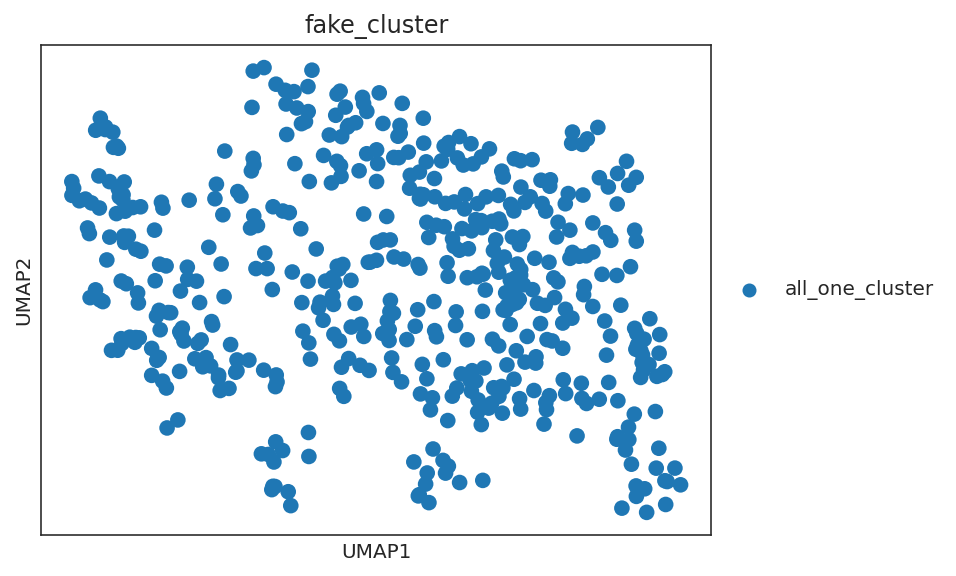

Working on results/cellTypeSpecificCellNetHuGene_v1/7.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/195 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 177 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 ASCL2 ATF1 
Prediction failed for ATF1 with error Gene ATF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF1 
Prediction failed for ATF1 with error Gene ATF1 is not included in 

ELF1 ELF1 ELF5 
Prediction failed for ELF5 with error Gene ELF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELF5 
Prediction failed for ELF5 with error Gene ELF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Can

IKZF1 IKZF1 IRF1 IRF1 IRF3 
Prediction failed for IRF3 with error Gene IRF3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IRF3 
Prediction failed for IRF3 with error Gene IRF3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IRF4 IRF4 IRF5 IRF5 ISL2 
Prediction failed for ISL2 with error Gene ISL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ISL2 
Prediction failed for ISL2 with error Gene ISL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JAG1 
Prediction failed for JAG1 with error Gene JAG1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JAG1 
Prediction failed for JAG1 with error Gene JAG1 is not included in the base GRN; It is not TF or TF motif i

NFATC1 NFATC1 NFE2L1 
Prediction failed for NFE2L1 with error Gene NFE2L1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFIC 
Prediction failed for NFIC with error Gene NFIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFIC 
Prediction failed for NFIC with error Gene NFIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFYB 
Prediction failed for NFYB with error Gene NFYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFYB 
Prediction failed for NFYB with error Gene NFYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NKX2-1 
Prediction failed for NKX2-1 with error Gene NKX2-1 is not included in the base GRN; It is not TF or TF motif information is no

RUNX1 RUNX1 RUNX3 RUNX3 RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RUVBL2 
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SAP30 
Prediction failed for SAP30 with error Gene SAP30 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIM1 
Prediction failed for SIM1 with error Gene SIM1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIM1 
Prediction failed for SIM1 with error Gene SIM1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIN3A 
Prediction failed for SIN3A with error Gene SIN3A is not included in the base GRN; It is not TF or TF motif i

TCF7L2 TCF7L2 TEAD4 TEAD4 TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2C 
Prediction failed for TFAP2C with error Gene TFAP2C is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2C 
Prediction failed for TFAP2C with error Gene TFAP2C is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFCP2L1 
Prediction failed for TFCP2L1 with error Gene TFCP2L1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFCP2L1 
Prediction failed for TFCP2L1 with error Gene TFCP2L1 is not included in the base GRN; 

KLF6 KLF6 LBX2 
Prediction failed for LBX2 with error Gene LBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
LBX2 
Prediction failed for LBX2 with error Gene LBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MLLT1 
Prediction failed for MLLT1 with error Gene MLLT1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MLLT1 
Prediction failed for MLLT1 with error Gene MLLT1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MXD3 
Prediction failed for MXD3 with error Gene MXD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MXD3 
Prediction failed for MXD3 with error Gene MXD3 is not included in the base GRN; It is not TF or TF motif information is not availabl

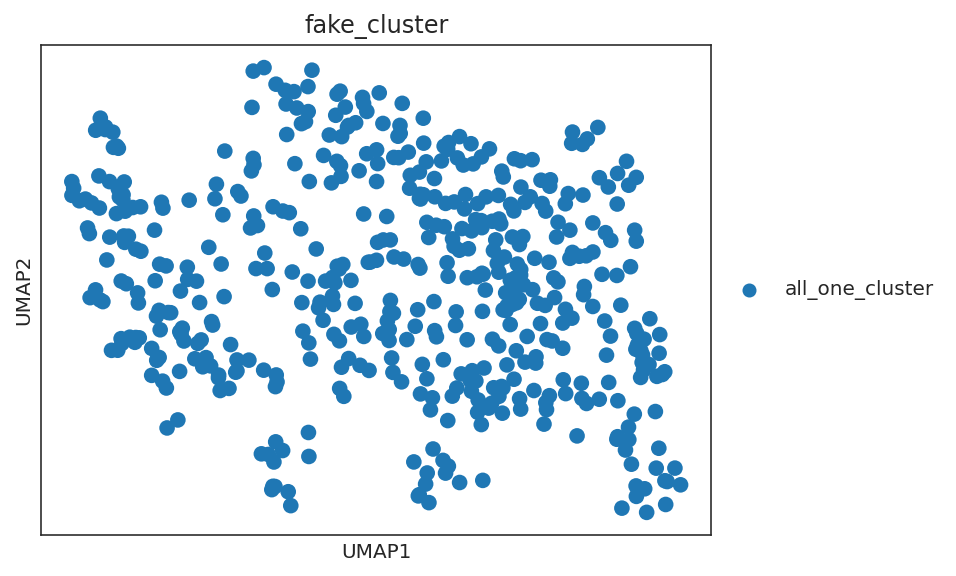

Working on results/cellTypeSpecificCellNetHuGene_v1/8.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/122 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 100 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the ba

EN1 EN1 EOMES 
Prediction failed for EOMES with error Gene EOMES is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EOMES 
Prediction failed for EOMES with error Gene EOMES is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESRRA 
Prediction failed for ESRRA with error Gene ESRRA does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ESRRA 
Prediction failed for ESRRA with error Gene ESRRA does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ESRRB 
Prediction failed for ESRRB with error Gene ESRRB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESRRB 
Prediction failed for ESRRB with error Gene ESRRB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESRRG ESRRG ESX1 
Predic

MYF6 MYF6 NANOG 
Prediction failed for NANOG with error Gene NANOG is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NANOG 
Prediction failed for NANOG with error Gene NANOG is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD1 
Prediction failed for NEUROD1 with error Gene NEUROD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROD1 
Prediction failed for NEUROD1 with error Gene NEUROD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG1 
Prediction failed for NEUROG1 with error Gene NEUROG1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG1 
Prediction failed for NEUROG1 with error Gene NEUROG1 is not included in the base GRN; It is not TF or 

SNAI3 SNAI3 SOX10 
Prediction failed for SOX10 with error Gene SOX10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX10 
Prediction failed for SOX10 with error Gene SOX10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX15 
Prediction failed for SOX15 with error Gene SOX15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX15 
Prediction failed for SOX15 with error Gene SOX15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX17 
Prediction failed for SOX17 with error Gene SOX17 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX17 
Prediction failed for SOX17 with error Gene SOX17 is not included in the base GRN; It is not TF or TF motif information i

ZIC1 ZIC1 ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMAT4 
Prediction failed for ZMAT4 with error Gene ZMAT4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMAT4 
Prediction failed for ZMAT4 with error Gene ZMAT4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMYND12 
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMYND12 
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or 

SATB1 SATB1 TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TEAD2 
Prediction failed for TEAD2 with error Gene TEAD2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TEAD2 
Prediction failed for TEAD2 with error Gene TEAD2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TEF TEF THRA 
Prediction failed for THRA with error Gene THRA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THRA 
Prediction failed for THRA with error Gene THRA is not included in the base GRN; It is not TF or TF motif information

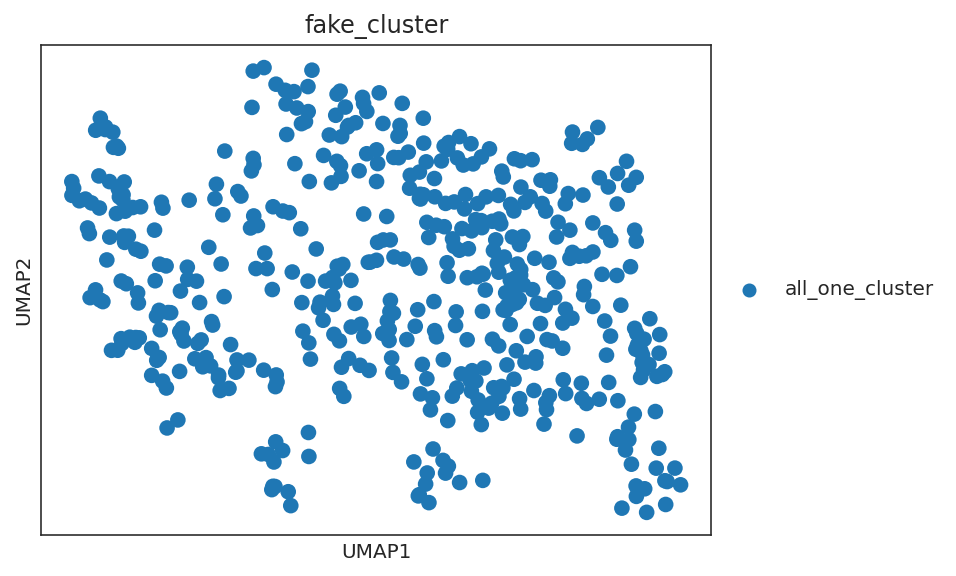

Working on results/cellTypeSpecificCellNetHuGene_v1/9.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/78 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 66 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the bas

EHF EHF ELF1 
Prediction failed for ELF1 with error Gene ELF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELF1 
Prediction failed for ELF1 with error Gene ELF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELF5 ELF5 ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not availa

GRHL2 GRHL2 GSC 
Prediction failed for GSC with error Gene GSC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GSC 
Prediction failed for GSC with error Gene GSC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2F1 
Prediction failed for GTF2F1 with error Gene GTF2F1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2F1 
Prediction failed for GTF2F1 with error Gene GTF2F1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF3C2 
Prediction failed for GTF3C2 with error Gene GTF3C2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF3C2 
Prediction failed for GTF3C2 with error Gene GTF3C2 is not included in the base GRN; It is not TF or TF motif information i

PAX2 PAX2 PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PITX3 
Prediction failed for PITX3 with error Gene PITX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PITX3 
Prediction failed for PITX3 with error Gene PITX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PML 
Prediction failed for PML with error Gene PML is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PML 
Prediction failed for PML with error Gene PML is not included in the base GRN; It is not TF or TF motif information is not av

TCF4 TCF4 TCF7L2 
Prediction failed for TCF7L2 with error Gene TCF7L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF7L2 
Prediction failed for TCF7L2 with error Gene TCF7L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TEAD4 
Prediction failed for TEAD4 with error Gene TEAD4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TEAD4 
Prediction failed for TEAD4 with error Gene TEAD4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif inf

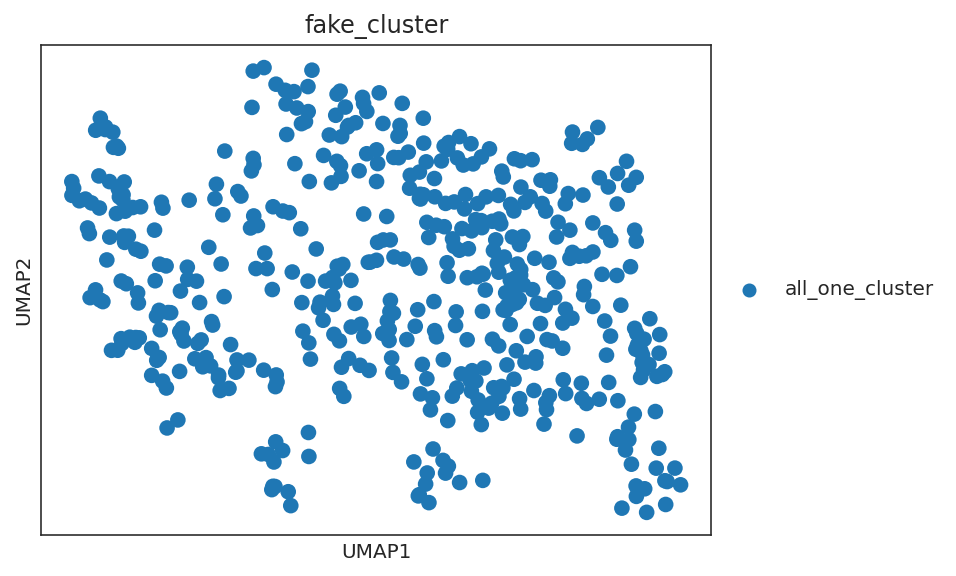

Working on results/cellTypeSpecificCellNetHuGene_v1/10.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/199 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 136 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 ARNT2 ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF1 
Prediction failed for ATF1 with error Gene ATF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ATF1 
Prediction failed for ATF1 with error Gene ATF1 is not included in 

ELK3 ELK3 ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EOMES 
Prediction failed for EOMES with error Gene EOMES is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EOMES 
Prediction failed for EOMES with error Gene EOMES is not included in the base GRN; It is not TF or TF motif information is not available. Can

HHEX HHEX HMGA2 
Prediction failed for HMGA2 with error Gene HMGA2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGA2 
Prediction failed for HMGA2 with error Gene HMGA2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGXB4 
Prediction failed for HMGXB4 with error Gene HMGXB4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
HMGXB4 
Prediction failed for HMGXB4 with error Gene HMGXB4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
HNF1A 
Prediction failed for HNF1A with error Gene HNF1A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOPX 
Prediction failed for HOPX with error Gene HOPX is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOPX 
Prediction fa

MEIS1 MEIS1 MNX1 
Prediction failed for MNX1 with error Gene MNX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MNX1 
Prediction failed for MNX1 with error Gene MNX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSX2 
Prediction failed for MSX2 with error Gene MSX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSX2 
Prediction failed for MSX2 with error Gene MSX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MXI1 MXI1 MYB 
Prediction failed for MYB with error Gene MYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYB 
Prediction failed for MYB with error Gene MYB is not included in the base GRN; It is not TF or TF motif information is not availabl

PML PML POLR3A 
Prediction failed for POLR3A with error Gene POLR3A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POLR3A 
Prediction failed for POLR3A with error Gene POLR3A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POU2AF1 
Prediction failed for POU2AF1 with error Gene POU2AF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POU2AF1 
Prediction failed for POU2AF1 with error Gene POU2AF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POU3F2 
Prediction failed for POU3F2 with error Gene POU3F2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POU3F2 
Prediction failed for POU3F2 with error Gene POU3F2 is not included in the base GRN; It is not TF or TF

SOX17 SOX17 SOX7 SOX7 SPI1 
Prediction failed for SPI1 with error Gene SPI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPI1 
Prediction failed for SPI1 with error Gene SPI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIB 
Prediction failed for SPIB with error Gene SPIB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIB 
Prediction failed for SPIB with error Gene SPIB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIC 
Prediction failed for SPIC with error Gene SPIC is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPIC 
Prediction failed for SPIC with error Gene SPIC is not included in the base GRN; It is not TF or TF motif information is not av

VDR VDR VPS72 
Prediction failed for VPS72 with error Gene VPS72 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
VPS72 
Prediction failed for VPS72 with error Gene VPS72 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
WNT3A 
Prediction failed for WNT3A with error Gene WNT3A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
WNT3A 
Prediction failed for WNT3A with error Gene WNT3A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
WT1 
Prediction failed for WT1 with error Gene WT1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
WT1 
Prediction failed for WT1 with error Gene WT1 is not included in the base GRN; It is not TF or TF motif information is not available.

PGF PGF PRICKLE1 
Prediction failed for PRICKLE1 with error Gene PRICKLE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SATB1 
Prediction failed for SATB1 with error Gene SATB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SATB1 
Prediction failed for SATB1 with error Gene SATB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TEAD2 
Prediction failed for TEAD2 with error Gene TEAD2 is not included in the base GRN; It is not TF or TF motif informat

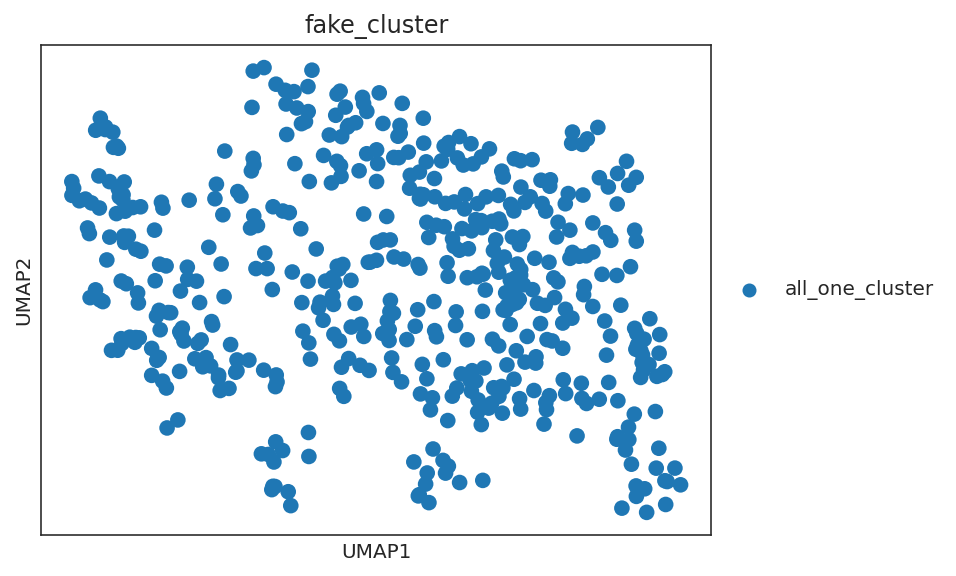

Working on results/cellTypeSpecificCellNetHuGene_v1/11.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/75 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 45 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the bas

FOXA1 FOXA1 FOXA2 FOXA2 FOXB1 
Prediction failed for FOXB1 with error Gene FOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXB1 
Prediction failed for FOXB1 with error Gene FOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXC1 
Prediction failed for FOXC1 with error Gene FOXC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXC1 
Prediction failed for FOXC1 with error Gene FOXC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXD1 
Prediction failed for FOXD1 with error Gene FOXD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXD1 
Prediction failed for FOXD1 with error Gene FOXD1 is not included in the base GRN; It is not TF or TF motif i

SPIC SPIC SPIC SPZ1 
Prediction failed for SPZ1 with error Gene SPZ1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPZ1 
Prediction failed for SPZ1 with error Gene SPZ1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
STAG1 
Prediction failed for STAG1 with error Gene STAG1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
STAG1 
Prediction failed for STAG1 with error Gene STAG1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
STAT3 
Prediction failed for STAT3 with error Gene STAT3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
STAT3 
Prediction failed for STAT3 with error Gene STAT3 is not included in the base GRN; It is not TF or TF motif information is n

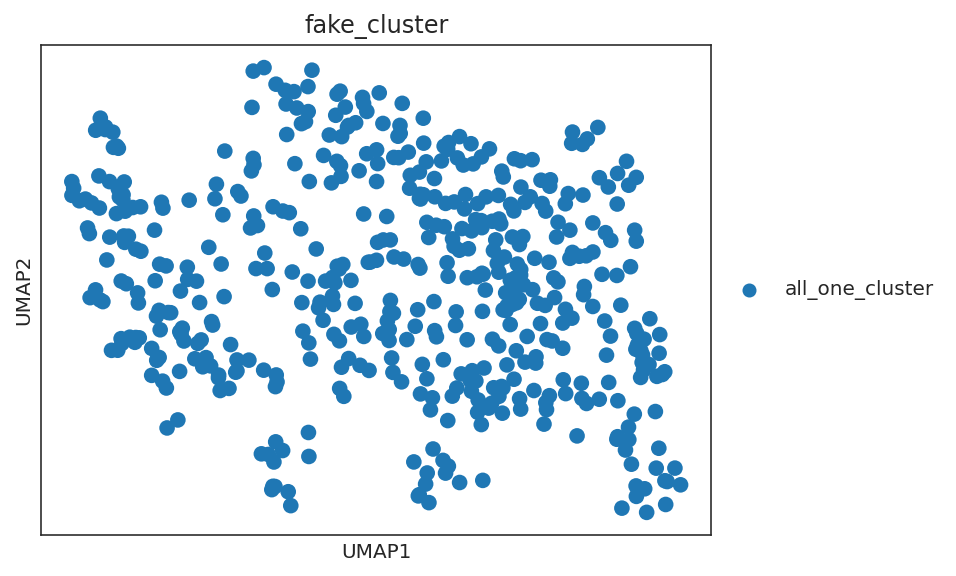

Working on results/cellTypeSpecificCellNetHuGene_v1/12.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/266 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 247 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the ba

ETS2 ETS2 ETV1 
Prediction failed for ETV1 with error Gene ETV1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV1 
Prediction failed for ETV1 with error Gene ETV1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV3 
Prediction failed for ETV3 with error Gene ETV3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV3 
Prediction failed for ETV3 with error Gene ETV3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV5 
Prediction failed for ETV5 with error Gene ETV5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV5 
Prediction failed for ETV5 with error Gene ETV5 is not included in the base GRN; It is not TF or TF motif information is not available. Can

HMGA2 HMGA2 HMGXB4 
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGXB4 
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HNF1A 
Prediction failed for HNF1A with error Gene HNF1A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOPX 
Prediction failed for HOPX with error Gene HOPX is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOPX 
Prediction failed for HOPX with error Gene HOPX is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA2 
Prediction failed for HOXA2 with error Gene HOXA2 is not included in the base GRN; It is not TF or TF motif information i

LMO2 LMO2 MAB21L3 
Prediction failed for MAB21L3 with error Gene MAB21L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MAB21L3 
Prediction failed for MAB21L3 with error Gene MAB21L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MAFK 
Prediction failed for MAFK with error Gene MAFK is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MAFK 
Prediction failed for MAFK with error Gene MAFK is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MEIS1 MEIS1 MNX1 
Prediction failed for MNX1 with error Gene MNX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MNX1 
Prediction failed for MNX1 with error Gene MNX1 is not included in the base GRN; It is not TF or TF motif inf

PATZ1 PATZ1 PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PITX3 
Prediction failed for PITX3 with error Gene PITX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PITX3 
Prediction failed for PITX3 with error Gene PITX3 is not included in the base GRN; It is not TF or TF motif information i

SMARCA4 SMARCA4 SMARCB1 
Prediction failed for SMARCB1 with error Gene SMARCB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMARCB1 
Prediction failed for SMARCB1 with error Gene SMARCB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMC3 
Prediction failed for SMC3 with error Gene SMC3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMC3 
Prediction failed for SMC3 with error Gene SMC3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI1 
Prediction failed for SNAI1 with error Gene SNAI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI1 
Prediction failed for SNAI1 with error Gene SNAI1 is not included in the base GRN; It is not TF or TF motif inf

WT1 WT1 YY1 
Prediction failed for YY1 with error Gene YY1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YY1 
Prediction failed for YY1 with error Gene YY1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB3 
Prediction failed for ZBTB3 with error Gene ZBTB3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB3 
Prediction failed for ZBTB3 with error Gene ZBTB3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB7A 
Prediction failed for ZBTB7A with error Gene ZBTB7A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZFP57 
Prediction failed for ZFP57 with error Gene ZFP57 is not included in the base GRN; It is not TF or TF motif information is not availab

HES6 HES6 HMGA1 HMGA1 HOXA1 
Prediction failed for HOXA1 with error Gene HOXA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA1 
Prediction failed for HOXA1 with error Gene HOXA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF6 KLF6 LBX2 
Prediction failed for LBX2 with error Gene LBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
LBX2 
Prediction failed for LBX2 with error Gene LBX2 is not included in the base GRN; It is not TF or TF motif

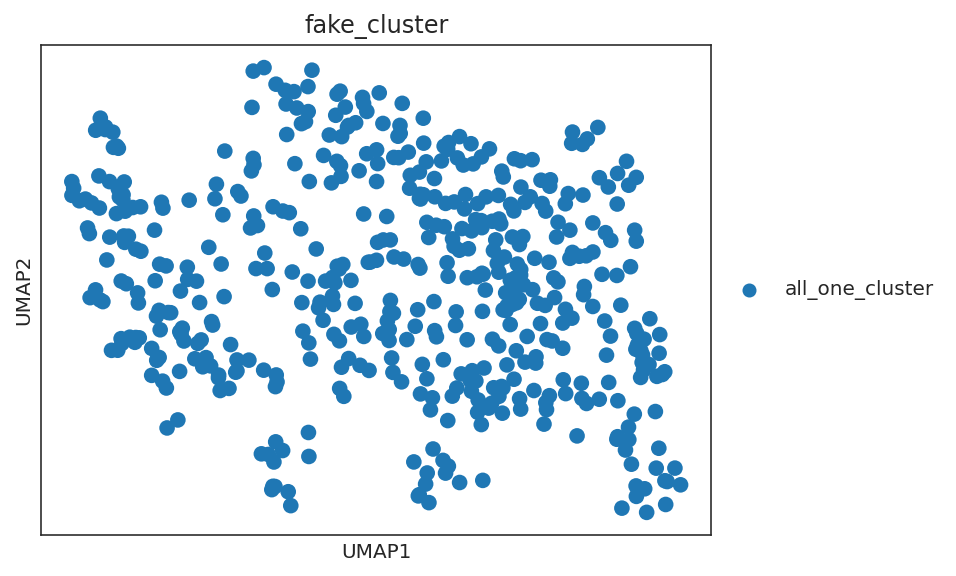

Working on results/cellTypeSpecificCellNetHuGene_v1/13.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/128 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 103 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the ba

ELF5 ELF5 ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot pe

JUN JUN JUNB JUNB JUNB KAT8 
Prediction failed for KAT8 with error Gene KAT8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KAT8 
Prediction failed for KAT8 with error Gene KAT8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KDM5A 
Prediction failed for KDM5A with error Gene KDM5A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KDM5A 
Prediction failed for KDM5A with error Gene KDM5A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KDM5B 
Prediction failed for KDM5B with error Gene KDM5B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KDM5B 
Prediction failed for KDM5B with error Gene KDM5B is not included in the base GRN; It is not TF or TF motif informat

NEUROG1 NEUROG1 NEUROG2 
Prediction failed for NEUROG2 with error Gene NEUROG2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG2 
Prediction failed for NEUROG2 with error Gene NEUROG2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG3 
Prediction failed for NEUROG3 with error Gene NEUROG3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NEUROG3 
Prediction failed for NEUROG3 with error Gene NEUROG3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFATC1 NFATC1 NFE2L1 
Prediction failed for NFE2L1 with error Gene NFE2L1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFIC 
Prediction failed for NFIC with error Gene NFIC is not included in the base G

RASL10A RASL10A REPIN1 
Prediction failed for REPIN1 with error Gene REPIN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
REPIN1 
Prediction failed for REPIN1 with error Gene REPIN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
REST 
Prediction failed for REST with error Gene REST is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
REST 
Prediction failed for REST with error Gene REST is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RFX2 RFX2 RFXAP 
Prediction failed for RFXAP with error Gene RFXAP is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RFXAP 
Prediction failed for RFXAP with error Gene RFXAP is not included in the base GRN; It is not TF or TF motif

TBX2 TBX2 TBX3 
Prediction failed for TBX3 with error Gene TBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX3 
Prediction failed for TBX3 with error Gene TBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX4 TBX4 TBX5 TBX5 TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF12 
Prediction failed for TCF12 with error Gene TCF12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF12 
Prediction failed for TCF12 with error Gene TCF12 is not included in the base GRN; It is not TF or TF motif informa

FOSB FOSB HES6 
Prediction failed for HES6 with error Gene HES6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HES6 
Prediction failed for HES6 with error Gene HES6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGA1 
Prediction failed for HMGA1 with error Gene HMGA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGA1 
Prediction failed for HMGA1 with error Gene HMGA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA1 
Prediction failed for HOXA1 with error Gene HOXA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA1 
Prediction failed for HOXA1 with error Gene HOXA1 is not included in the base GRN; It is not TF or TF motif information is not av

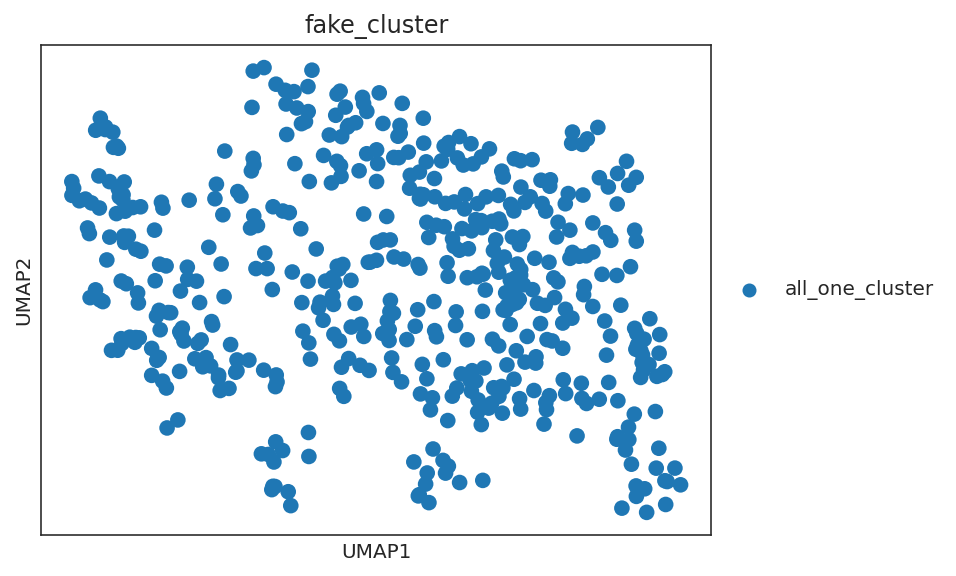

Working on results/cellTypeSpecificCellNetHuGene_v1/14.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.
Total number of TF was 41. Although we can go to the GRN calculation with this data, but the TF number is small.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/41 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 41 genes
Predicting ZSCAN5A
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX3 
Prediction failed for ALX3 with error Gene ALX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ARNT2 
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ASCL2 
Prediction failed for ASCL2 with error Gene ASCL2 is not included in the bas

ELF5 ELF5 ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELK3 
Prediction failed for ELK3 with error Gene ELK3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot pe

HOPX HOPX HOXA2 
Prediction failed for HOXA2 with error Gene HOXA2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA2 
Prediction failed for HOXA2 with error Gene HOXA2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA9 
Prediction failed for HOXA9 with error Gene HOXA9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA9 
Prediction failed for HOXA9 with error Gene HOXA9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXB1 
Prediction failed for HOXB1 with error Gene HOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXB1 
Prediction failed for HOXB1 with error Gene HOXB1 is not included in the base GRN; It is not TF or TF motif information is 

MAB21L3 MAB21L3 MAFK 
Prediction failed for MAFK with error Gene MAFK is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MAFK 
Prediction failed for MAFK with error Gene MAFK is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MEIS1 
Prediction failed for MEIS1 with error Gene MEIS1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MEIS1 
Prediction failed for MEIS1 with error Gene MEIS1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MNX1 
Prediction failed for MNX1 with error Gene MNX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MNX1 
Prediction failed for MNX1 with error Gene MNX1 is not included in the base GRN; It is not TF or TF motif information is not av

TFAP2A TFAP2A TFAP2C TFAP2C TFCP2L1 
Prediction failed for TFCP2L1 with error Gene TFCP2L1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFCP2L1 
Prediction failed for TFCP2L1 with error Gene TFCP2L1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TGIF1 
Prediction failed for TGIF1 with error Gene TGIF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TGIF1 
Prediction failed for TGIF1 with error Gene TGIF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TGM2 
Prediction failed for TGM2 with error Gene TGM2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TGM2 
Prediction failed for TGM2 with error Gene TGM2 is not included in the base GRN; It is not TF or 

BMP7 BMP7 BRF1 
Prediction failed for BRF1 with error Gene BRF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
BRF1 
Prediction failed for BRF1 with error Gene BRF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CBFB 
Prediction failed for CBFB with error Gene CBFB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CTBP1 
Prediction failed for CTBP1 with error Gene CTBP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CTBP1 
Prediction failed for CTBP1 with error Gene CTBP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CXXC5 
Prediction failed for CXXC5 with error Gene CXXC5 is not included in the base GRN; It is not TF or TF motif information is not avail

In [12]:
predictions = {
    i: evaluator.trainCausalModelAndPredict(expression=ko_lab_esc_data_train,
                                  baseNetwork=networks[experiments.loc[i,'network']],
                                  memoizationName="results/" + EXPERIMENT_NAME + "/" + str(i) + ".celloracle.oracle", 
                                  perturbations=perturbationsToPredict,
                                  clusterColumnName = "fake_cluster",
                                  pruningParameters = {"p":experiments.loc[i,'p'], 
                                                       "threshold_number":experiments.loc[i,'threshold_number']}) 
    for i in experiments.index
}


In [13]:
predictions[0]

{'ALX3': ArrayView([0.31787362, 0.26555526, 0.35006813, ..., 0.51548357,
            0.28077881, 1.07324214]),
 'ARNT2': ArrayView([0.28353897, 0.23874468, 0.34349491, ..., 0.48157308,
            0.27320929, 1.06515696]),
 'ASCL2': ArrayView([0.31501106, 0.25897231, 0.35430694, ..., 0.51224682,
            0.28061757, 1.07027102]),
 'ATF1': ArrayView([0.32699184, 0.26490541, 0.36917727, ..., 0.51563047,
            0.30010019, 1.05956319]),
 'ATF3': ArrayView([0.32233458, 0.30263167, 0.4172652 , ..., 0.48242717,
            0.2569705 , 1.05574006]),
 'BARX2': ArrayView([0.31759715, 0.25692903, 0.35002558, ..., 0.50957034,
            0.27853291, 1.0681604 ]),
 'BATF': ArrayView([0.32323168, 0.27152519, 0.34749868, ..., 0.51044779,
            0.28141901, 1.07286587]),
 'BCL6': ArrayView([0.32902557, 0.27999627, 0.31781784, ..., 0.49561525,
            0.31394969, 1.09176238]),
 'BLZF1': ArrayView([0.31925196, 0.25728144, 0.36228182, ..., 0.50340472,
            0.27705853, 1.07601619]

### Evaluation

We compute the correlation of the predictions with held-out perturbations.

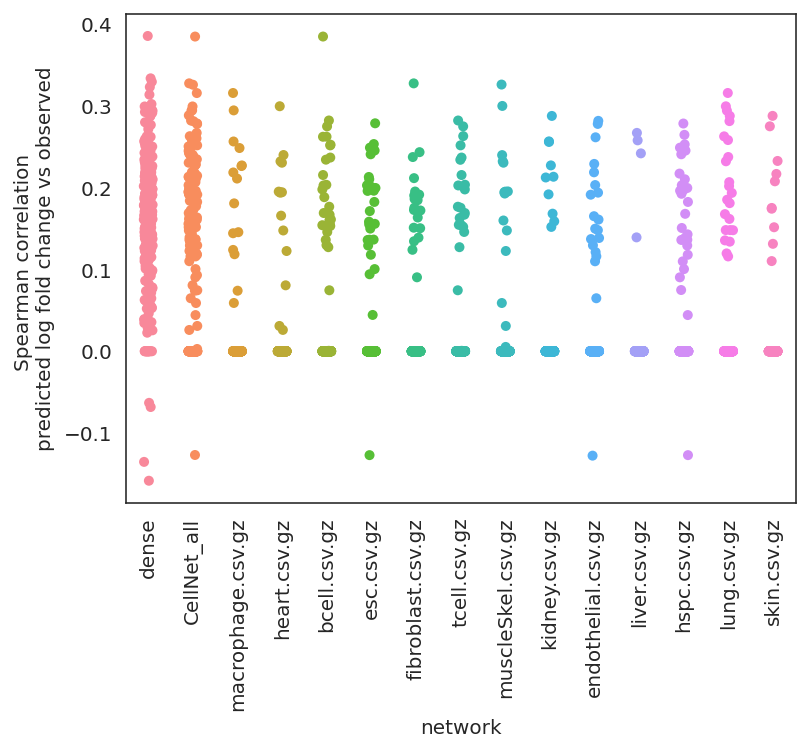

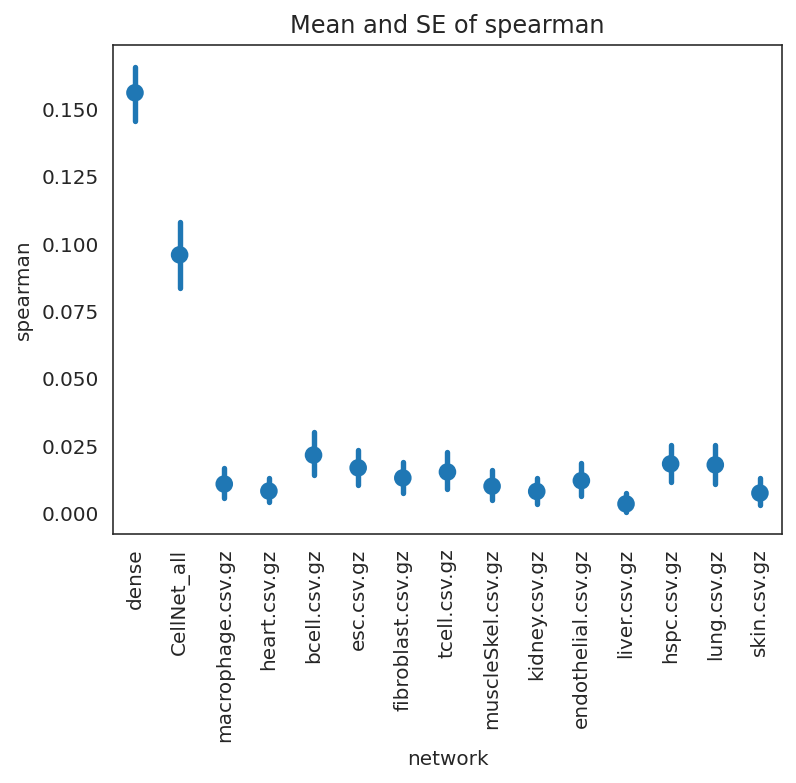

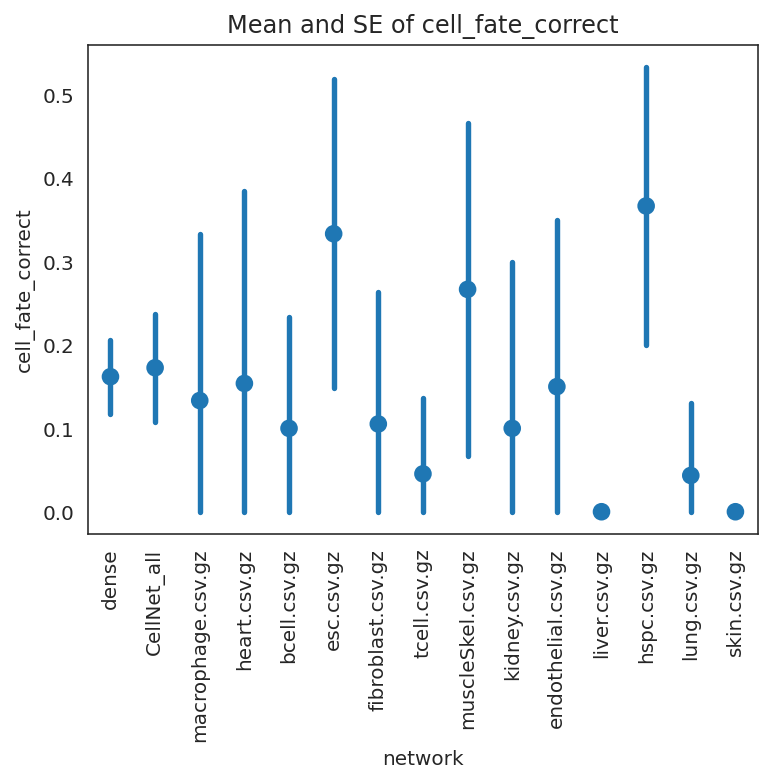

(      spearman     spearmanp  cell_fate_correct perturbation  index  \
 0     0.237572  1.007258e-34                0.0         ALX3      0   
 1     0.174008  3.827145e-19                0.0        ARNT2      0   
 2     0.167099  9.355592e-18                0.0        ASCL2      0   
 3     0.137168  2.093105e-12                0.0         ATF1      0   
 4     0.188078  3.756498e-22                0.0         ATF3      0   
 ...        ...           ...                ...          ...    ...   
 3940  0.000000  1.000000e+00                NaN       ZBTB44     14   
 3941  0.000000  1.000000e+00                NaN        ZMAT5     14   
 3942  0.000000  1.000000e+00                NaN       ZNF384     14   
 3943  0.000000  1.000000e+00                NaN       ZNF480     14   
 3944  0.000000  1.000000e+00                NaN      ZSCAN5A     14   
 
           network  p  threshold_number pruning  somePredictionRefused  
 0           dense  1         102313295    none              

<Figure size 432x324 with 0 Axes>

In [14]:
controlIndex = ko_lab_esc_data_train.obs["perturbation"]=="Control"
evaluator.evaluateCausalModel(heldout = ko_lab_esc_data_heldout, 
                    predictions = predictions,   
                    baseline = ko_lab_esc_data_train[controlIndex,:].X.mean(axis=0), 
                    classifier=cellFateClassifier, 
                    experiments = experiments,
                    factor_varied = "network",
                    experiment_name = EXPERIMENT_NAME)